# Weekly demand-prediction with perturbed prices

## Model and training
- `wm_yr_wk`: 11130 - 11612 (d_1 - d_1911)
- Data shape
    - \# of dense columns: 12
    - \# of cat columns: 5
- Data split
    - train: `wm_yr_wk` 11130 - 11604
    - valid: `wm_yr_wk` 11605 - 11608 (4 weeks)
    - test: `wm_yr_wk` 11609 - 11612 (4 weeks)

## Baselines
- Linear models
    - Ordinary least squares (OLS)
    - 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import gc
import os
import importlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import utils

datapath = 'data'
weekly_filename = 'week_price_demand_corr-0.6.csv'

df_input = pd.read_csv(os.path.join(datapath, weekly_filename), index_col=0)
df_input.head()

week_dense_cols = ['week_sell_price', 'week_sell_price_rel_diff', 'week_sell_price_roll_sd7', 'week_sell_price_cumrel', 
                   'week_lag_t28', 'week_rolling_mean_t7', 'week_rolling_mean_t30', 'week_rolling_mean_t60', 'week_rolling_mean_t90', 
                   'week_rolling_mean_t180', 'week_rolling_std_t7', 'week_rolling_std_t30']
cat_cols = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']


target_scaler = 10.

# Rest is used for training
flag = df_input['wm_yr_wk'] < 11605
train_x = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
train_y = df_input['week_sum_demand'][flag]/target_scaler

# One month of validation data
flag = (df_input['wm_yr_wk'] < 11609) & (df_input['wm_yr_wk'] >= 11605)
valid_x = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
valid_y = df_input['week_sum_demand'][flag]/target_scaler

# Submission data
flag = df_input['wm_yr_wk'] >= 11609
test_x = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
test_y = df_input['week_sum_demand'][flag]/target_scaler

del flag
gc.collect()


# data_info = {'item_id': 262, 'dept_id': 7, 'store_id': 10, 'cat_id': 3, 'state_id': 3, 'dense1': 12}
# data_info = {'dense1': 12}

0

## Data preprocessing for baselines

In [4]:
from sklearn.preprocessing import OneHotEncoder

def merge_one_hot_encodings(dict_input):
    tmp = np.concatenate((dict_input['item_id'], 
                          dict_input['dept_id'], 
                          dict_input['store_id'], 
                          dict_input['cat_id'], 
                          dict_input['state_id']), axis=1)
    enc = OneHotEncoder(handle_unknown='ignore')
    ret = enc.fit_transform(tmp).toarray()
    
    return ret, enc


dense_only = True

if dense_only:
    train_x_np = np.copy(train_x['dense1'])
    valid_x_np = np.copy(valid_x['dense1'])
    test_x_np = np.copy(test_x['dense1'])

else:
    train_x_np, _ = merge_one_hot_encodings(train_x)
    train_x_np = np.concatenate((train_x['dense1'], train_x_np), axis=1)
    valid_x_np, _ = merge_one_hot_encodings(valid_x)
    valid_x_np = np.concatenate((valid_x['dense1'], valid_x_np), axis=1)
    test_x_np, _ = merge_one_hot_encodings(test_x)
    test_x_np = np.concatenate((test_x['dense1'], test_x_np), axis=1)

train_y_np = train_y.to_numpy()
valid_y_np = valid_y.to_numpy()
test_y_np = test_y.to_numpy()

# Perturbations on price
pert_test_x = test_x_np.copy()
perturbations = 1.0*np.random.rand(test_x_np.shape[0])    # small positive price
pert_test_x[:,0] += perturbations    # 0-th feature : week_sell_price

print('input shape: {}'.format(train_x_np.shape))

input shape: (92588, 12)


## Scikit baselines

In [5]:
"""
Ordinary least squares
"""
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from utils_metric import verification

reg = LinearRegression(normalize=False, fit_intercept=False).fit(train_x_np, train_y_np)

output = reg.predict(test_x_np)

print('# features : ', train_x_np.shape[1])

print('Mean squared error: %.6f' % mean_squared_error(test_y_np, output))
print('Mean absolute error: %.6f' % mean_absolute_error(test_y_np, output))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(test_y_np, output))

# Perturbed input and output
pert_output = reg.predict(pert_test_x)    # \hat{y}_{p}    predicted sales from perturbed input
test_ratio = verification(output, pert_output, threshold=0.0).item()

print('Verification ratio: ', test_ratio)
if len(reg.coef_) < 20: print(reg.coef_, reg.intercept_)

# features :  12
Mean squared error: 1.746139
Mean absolute error: 0.686966
Coefficient of determination: 0.86
Verification ratio:  0.0
[ 0.01377761 -1.47494848  1.27740469 -0.30086065  0.24735449  0.12829645
 -0.01002813  0.19871382 -0.04749313  0.13815571 -0.04486083  0.06021513] 0.0


In [13]:
'''
ridge / lasso
'''

from sklearn import linear_model

reg = linear_model.Ridge(alpha=0.01).fit(train_x_np, train_y_np)
# reg = linear_model.Lasso(alpha=0.01).fit(train_x_np, train_y_np)

output = reg.predict(test_x_np)

print('Mean squared error: %.6f' % mean_squared_error(test_y_np, output))
print('Mean absolute error: %.6f' % mean_absolute_error(test_y_np, output))

# Perturbed input and output
pert_output = reg.predict(pert_test_x)    # \hat{y}_{p}    predicted sales from perturbed input
test_ratio = verification(output, pert_output, threshold=0.0).item()

print('Verification ratio: ', test_ratio)

print('Verification ratio: ', test_ratio)
if len(reg.coef_) < 20: print(reg.coef_, reg.intercept_)

Mean squared error: 1.740464
Mean absolute error: 0.687433
Verification ratio:  1.0
Verification ratio:  1.0
[-4.98498054e-03 -1.35675165e+00  1.27943714e+00 -5.08191173e-01
  2.46342112e-01  1.31877150e-01 -4.18160592e-04  1.98473372e-01
 -4.58117746e-02  1.31622401e-01 -5.53804384e-02  3.32631310e-02] 0.18683719627383244


In [14]:
'''
Gradient boosting
'''
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0).fit(train_x_np, train_y_np)

output = reg.predict(test_x_np)

print('Mean squared error: %.6f' % mean_squared_error(test_y_np, output))
print('Mean absolute error: %.6f' % mean_absolute_error(test_y_np, output))

# Perturbed input and output
pert_output = reg.predict(pert_test_x)    # \hat{y}_{p}    predicted sales from perturbed input
test_ratio = verification(output, pert_output, threshold=0.0).item()

print('Verification ratio: ', test_ratio)

Mean squared error: 1.704671
Mean absolute error: 0.673618
Verification ratio:  0.1817180616740088


torch.Size([1816, 12])

Mean squared error: 1.677435
Mean absolute error: 0.667688
Verification ratio:  0.1866740088105727


## PyTorch data preprocessing

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:3")
dtype = torch.double

train_x_torch = torch.tensor(train_x_np, device=device, dtype=dtype)
train_y_torch = torch.tensor(train_y_np, device=device, dtype=dtype)

valid_x_torch = torch.tensor(valid_x_np, device=device, dtype=dtype)
valid_y_torch = torch.tensor(valid_y_np, device=device, dtype=dtype)

test_x_torch = torch.tensor(test_x_np, device=device, dtype=dtype)
test_y_torch = torch.tensor(test_y_np, device=device, dtype=dtype)

train_loader = DataLoader(TensorDataset(train_x_torch, train_y_torch),
                          batch_size=128, shuffle=False)

## PyTorch Linear regression

In [384]:
from model_baselines import LinearRegression



input_dim = train_x_torch.shape[1]
output_dim = 1

model_lr = LinearRegression(input_dim, output_dim).to(dtype).to(device)
total_params = sum(p.numel() for p in model_lr.parameters())
print("total parameters in LinearRegression: {}".format(total_params))

loss_task = nn.L1Loss()
# loss_task = nn.L2Loss()
lr = 0.001
optimizer = optim.Adam(model_lr.parameters(), lr=lr)
# optimizer = optim.SGD(model_lr.parameters(), lr=lr)

epochs = 50
val_freq = 5
best_val_loss = float('inf')

saved_filename = 'm5_LR_weekly_demand_pred_with_pert_price.pt'
saved_filename =  os.path.join('saved_models', saved_filename)
print('saved_filename: {}\n'.format(saved_filename))

for epoch in range(epochs):
    for batch_idx, batch_data in enumerate(train_loader):
        batch_train_x = batch_data[0]    # input features
        batch_train_y = batch_data[1]
        
        optimizer.zero_grad()

        output = model_lr(batch_train_x)
#         loss = loss_task(output, batch_train_y)
        loss = nn.MSELoss()(output, batch_train_y)

        loss.backward()
        optimizer.step()
    
    print('[Train] Epoch: {}, loss: {:.6f}'.format(epoch, loss.item()))
    
    # Evaluate on validation set
    if epoch % val_freq == 0:
        model_lr.eval()
        with torch.no_grad():
            output = model_lr(valid_x_torch)
            val_loss = loss_task(output, valid_y_torch).item()
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('[Valid] Epoch: {} Loss: {:.6f}\t best model is updated %%%%'
                  .format(epoch, best_val_loss))
            torch.save({
                'epoch': epoch,
                'model_state_dict':model_lr.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss
            }, saved_filename)
        else:
            print('[Valid] Epoch: {} Loss: {:.6f}'.format(epoch, val_loss))
            
model_eval = LinearRegression(input_dim, output_dim).to(dtype).to(device)
checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

model_eval.eval()
with torch.no_grad():
    output = model_eval(test_x_torch)
    test_loss = loss_task(output, test_y_torch).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

total parameters in LinearRegression: 13
saved_filename: saved_models/m5_LR_weekly_demand_pred_with_pert_price.pt

[Train] Epoch: 0, loss: 0.206827
[Valid] Epoch: 0 Loss: 2.140066	 best model is updated %%%%
[Train] Epoch: 1, loss: 0.065689
[Train] Epoch: 2, loss: 0.055437
[Train] Epoch: 3, loss: 0.051835
[Train] Epoch: 4, loss: 0.049711
[Train] Epoch: 5, loss: 0.048090
[Valid] Epoch: 5 Loss: 2.094877	 best model is updated %%%%
[Train] Epoch: 6, loss: 0.046627
[Train] Epoch: 7, loss: 0.045197
[Train] Epoch: 8, loss: 0.043757
[Train] Epoch: 9, loss: 0.042301
[Train] Epoch: 10, loss: 0.040835
[Valid] Epoch: 10 Loss: 2.076462	 best model is updated %%%%
[Train] Epoch: 11, loss: 0.039374
[Train] Epoch: 12, loss: 0.037931
[Train] Epoch: 13, loss: 0.036521
[Train] Epoch: 14, loss: 0.035154
[Train] Epoch: 15, loss: 0.033840
[Valid] Epoch: 15 Loss: 2.069025	 best model is updated %%%%
[Train] Epoch: 16, loss: 0.032586
[Train] Epoch: 17, loss: 0.031396
[Train] Epoch: 18, loss: 0.030272
[Train]

## PyTorch implementation

In [17]:
'''
Data preprocessing for NN
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:3")
dtype = torch.double

def tensorize(dict_input, device='cpu'):
    for key, item in dict_input.items():
        if key == 'dense1':
            dict_input[key] = torch.tensor(item, dtype=dtype, device=device)
        else:
            dict_input[key] = torch.tensor(item, dtype=torch.int64, device=device)

# Tensorize
tensorize(train_x, device)
tensorize(valid_x, device)
tensorize(test_x, device)

if not isinstance(train_y, torch.Tensor):
    train_y = torch.tensor(train_y.to_numpy(), device=device, dtype=dtype)
    valid_y = torch.tensor(valid_y.to_numpy(), device=device, dtype=dtype)
    test_y = torch.tensor(test_y.to_numpy(), device=device, dtype=dtype)


name_to_ind = {'dense1': 0, 'item_id': 1, 'dept_id': 2, 'store_id': 3, 'cat_id': 4, 'state_id': 5}

if dense_only:
    train_loader = DataLoader(TensorDataset(train_x['dense1'], train_y), batch_size=128, shuffle=False)
    valid_x_list = [valid_x['dense1']]
    test_x_list = [test_x['dense1']]
    data_info = {'dense1': 12}
    
else:
    train_loader = DataLoader(TensorDataset(train_x['dense1'], 
                                            train_x['item_id'].squeeze(), 
                                            train_x['dept_id'].squeeze(), 
                                            train_x['store_id'].squeeze(), 
                                            train_x['cat_id'].squeeze(), 
                                            train_x['state_id'].squeeze(),
                                            train_y),
                              batch_size=128, shuffle=False)
    valid_x_list = [valid_x['dense1'], valid_x['item_id'].squeeze(), valid_x['dept_id'].squeeze(), 
                    valid_x['store_id'].squeeze(), valid_x['cat_id'].squeeze(), valid_x['state_id'].squeeze()]
    test_x_list = [test_x['dense1'], test_x['item_id'].squeeze(), test_x['dept_id'].squeeze(), 
                   test_x['store_id'].squeeze(), test_x['cat_id'].squeeze(), test_x['state_id'].squeeze()]
    data_info = {'item_id': 262, 'dept_id': 7, 'store_id': 10, 'cat_id': 3, 'state_id': 3, 'dense1': 12}
    


print("data size: {}/{}/{}".format(len(train_y), len(valid_y), len(test_y)))

data size: 92588/1816/1816


In [21]:
from model import RuleEncoder, DataEncoder, M5Net
    
input_dim = 12 if dense_only else 19
hidden_dim = 64
emb_dim = 16
output_dim = 1

lr = 0.001
rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim).to(dtype)
data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim).to(dtype)
model = M5Net(data_info, rule_encoder, data_encoder, name_to_ind, hidden_dim).to(dtype).to(device)    # absolute prediction

rule_weight = torch.tensor(model.rule_encoder.net[0].weight)
data_weight = torch.tensor(model.data_encoder.net[0].weight)

total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_rule = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
loss_task = nn.L1Loss()    # return scalar (reduction=mean)
optimizer = optim.Adam(model.parameters(), lr=lr)



model_type = 'data-only'
# model_type = 'hybrid'    # based on perturbations

epochs = 50
log_interval = 1000
val_freq = 5

if dense_only:
    saved_filename = 'm5_{}_weekly_demand_pred_with_pert_price_denseonly.pt'.format(model_type)
else:
    saved_filename = 'm5_{}_weekly_demand_pred_with_pert_price.pt'.format(model_type)

saved_filename =  os.path.join('saved_models', saved_filename)
print('saved_filename: {}\n'.format(saved_filename))
best_val_loss = float('inf')




# Training
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):

        batch_train_x = batch_data[:-1]    # input features
        batch_train_y = batch_data[-1]
        
        optimizer.zero_grad()
        
        if model_type == 'data-only':
            alpha = 0.0
        elif model_type == 'rule-only':
            alpha = 1.0
        else:
            alpha = torch.rand(1).item()

        # stable output
        output = model(batch_train_x, alpha=alpha)    # only rule if alpha=1.    \hat{X}_{t+1}
        loss_state = loss_task(output, batch_train_y)    # state prediction
        
        
        # perturbed input and its output
        pert_batch_train_x = []
        for _train_x in batch_train_x:
             pert_batch_train_x.append(_train_x.detach().clone())
                
        # Perturbations on price
        perturbations = 1.0*torch.rand((batch_train_x[0].shape[0], ), device=device)    # two angular velocities
        pert_batch_train_x[0][:,0] += perturbations    # 0-th feature : week_sell_price
            
        pert_output = model(pert_batch_train_x, alpha=alpha)    # \hat{y}_{p}    predicted sales from perturbed input
            
        loss_pert = loss_rule(pert_output, output)    # pert_output should be less than output

        # weighted loss
        loss = alpha*loss_pert + (1-alpha)*loss_state    # price elasticity of demand + state prediction
            
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print('[Train] Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} (alpha: {:.4f})'.format(
                epoch, batch_idx * len(batch_train_x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), alpha))


    # Evaluate on validation set
    if epoch % val_freq == 0:
        model.eval()
        with torch.no_grad():
            target = valid_y
            output = model(valid_x_list, alpha=0.0)
            val_loss = loss_task(output, target).item()
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('[Valid] Epoch: {} Loss: {:.6f} (alpha: 0.0)\t best model is updated %%%%'
                  .format(epoch, best_val_loss))
            torch.save({
                'epoch': epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss
            }, saved_filename)
        else:
            print('[Valid] Epoch: {} Loss: {:.6f} (alpha: 0.0)'.format(epoch, val_loss))
            

# Test
rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim).to(dtype)
data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim).to(dtype)
model_eval = M5Net(data_info, rule_encoder, data_encoder, name_to_ind, hidden_dim).to(dtype).to(device)    # absolute prediction

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

model_eval.eval()
with torch.no_grad():
    target = test_y
    output = model_eval(test_x_list, alpha=0.0)
    test_loss = loss_task(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

#### Check which parameters are updated.
print('Is rule_weight NOT udpated: {}'.format(torch.allclose(rule_weight, torch.tensor(model.rule_encoder.net[0].weight))))
print('Is data_weight NOT udpated: {}'.format(torch.allclose(data_weight, torch.tensor(model.data_encoder.net[0].weight))))

total parameters: 5921
saved_filename: saved_models/m5_data-only_weekly_demand_pred_with_pert_price_denseonly.pt

[Train] Epoch: 1 [0/92588 (0%)]	Loss: 1.984046 (alpha: 0.0000)


KeyboardInterrupt: 

In [86]:

'''
data only
    Test set: Average loss: 
    0.06818807 (40.8 %)
    0.07038089 (59.5 %)
    0.07064194 (38.5 %)
    0.07343948 (51.4 %)
    0.06992790 (54.4 %)
    0.07153082 (72.1 %)
hybrid
    0.06727948 (83.8 %) (alpha=?)
    0.06867212 (51.2 %)
    0.06546154 (77.9 %) (alpha=0.2)
    0.06666304 (70.3 %) (alpha=0.3)
    0.06695141 (79.6 %) (alpha=0.2)
    0.06656274 (82.7 %) (alpha=0.2)
    0.06788840 (85.3 %) (alpha=0.4)
'''
data_only_mae = [0.06818807, 0.07038089, 0.07064194, 0.07343948, 0.06992790]
data_only_ratio = [0.408, 0.595, 0.385, 0.514, 0.544]
hybrid_mae = [0.06546154, 0.06666304, 0.06695141, 0.06656274, 0.06788840]
hybrid_ratio = [0.779, 0.703, 0.796, 0.827, 0.853]

print('[Data-only] mean of MAEs : {:.6f} ({:.6f})'.format(np.mean(data_only_mae), np.std(data_only_mae)))
print('[Data-only] mean of verification ratio : {:.6f} ({:.6f})'.format(np.mean(data_only_ratio), np.std(data_only_ratio)))
print('[Hybrid] mean of MAEs : {:.6f} ({:.6f})'.format(np.mean(hybrid_mae), np.std(hybrid_mae)))
print('[Hybrid] mean of verification ratio : {:.6f} ({:.6f})'.format(np.mean(hybrid_ratio), np.std(hybrid_ratio)))

[Data-only] mean of MAEs : 0.070516 (0.001694)
[Data-only] mean of verification ratio : 0.489200 (0.080328)
[Hybrid] mean of MAEs : 0.066705 (0.000778)
[Hybrid] mean of verification ratio : 0.791600 (0.051091)


In [27]:
from model import RuleEncoder, DataEncoder, M5Net

input_dim = 12 if dense_only else 19
hidden_dim = 64
emb_dim = 16
output_dim = 1

# Test
rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim).to(dtype)
data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim).to(dtype)
model_eval = M5Net(data_info, rule_encoder, data_encoder, name_to_ind, hidden_dim).to(dtype).to(device)    # absolute prediction

# checkpoint = torch.load('saved_models/dp-data-only_-1.3171_0.0_1.3498_0.0.pt')
checkpoint = torch.load('saved_models/m5_hybrid_weekly_demand_pred_with_pert_price_denseonly.pt.bak')
# checkpoint = torch.load('saved_models/m5_data-only_weekly_demand_pred_with_pert_price_denseonly.pt')
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

model_eval.eval()
with torch.no_grad():
    target = test_y
    output = model_eval(test_x_list, alpha=0.0)
    test_loss = loss_task(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

best model loss: 0.645374	 at epoch: 35

Test set: Average loss: 0.63744889



Test set: Average loss: 0.63744889 (alpha:0.0)
ratio of verified predictions: 0.610683 (alpha:0.0)
Test set: Average loss: 0.65060866 (alpha:0.1)
ratio of verified predictions: 0.709251 (alpha:0.1)
Test set: Average loss: 0.67276679 (alpha:0.2)
ratio of verified predictions: 0.773678 (alpha:0.2)
Test set: Average loss: 0.69170891 (alpha:0.3)
ratio of verified predictions: 0.854626 (alpha:0.3)
Test set: Average loss: 0.70885479 (alpha:0.4)
ratio of verified predictions: 0.877753 (alpha:0.4)
Test set: Average loss: 0.72440797 (alpha:0.5)
ratio of verified predictions: 0.888216 (alpha:0.5)
Test set: Average loss: 0.73803571 (alpha:0.6)
ratio of verified predictions: 0.898128 (alpha:0.6)
Test set: Average loss: 0.75039209 (alpha:0.7)
ratio of verified predictions: 0.899780 (alpha:0.7)
Test set: Average loss: 0.76176925 (alpha:0.8)
ratio of verified predictions: 0.903634 (alpha:0.8)
Test set: Average loss: 0.77228053 (alpha:0.9)
ratio of verified predictions: 0.904185 (alpha:0.9)
Test set: 

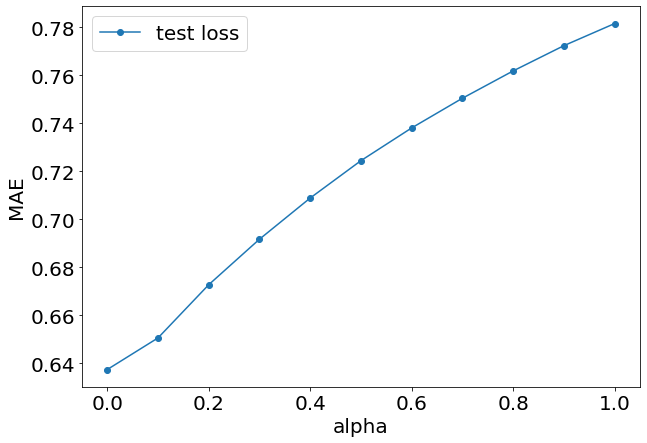

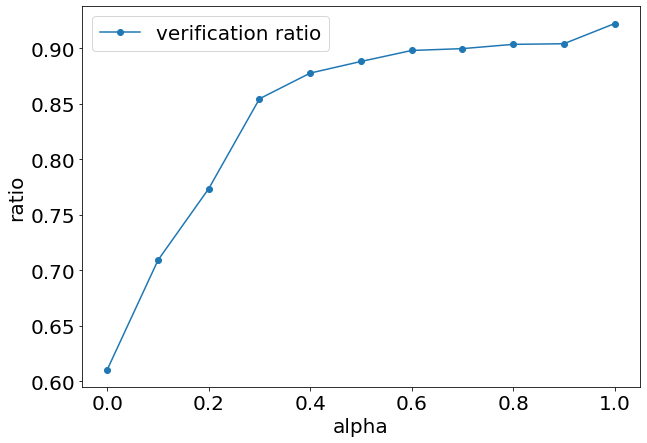

In [28]:



model = model_eval

test_loss_alpha = []
test_ratio_alpha = []
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for _alpha in alphas:

    model.eval()

    with torch.no_grad():
        target = test_y
        output = model(test_x_list, alpha=_alpha)
        test_loss = loss_task(output, target).item()  # sum up batch loss
        
        # perturbed input and its output
        pert_test_x = []
        for _test_x in test_x_list:
             pert_test_x.append(_test_x.detach().clone())
                
        # Perturbations on price
        perturbations =1.0*torch.rand((test_x_list[0].shape[0], ), device=device)    # two angular velocities
        pert_test_x[0][:,0] += perturbations    # 0-th feature : week_sell_price
            
        pert_output = model(pert_test_x, alpha=_alpha)    # \hat{y}_{p}    predicted sales from perturbed input
        
        test_ratio = verification(output, pert_output, threshold=0.0).item()

    print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss, _alpha))
    print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, _alpha))
    
    test_loss_alpha.append(test_loss)
    test_ratio_alpha.append(test_ratio)

    
    
plt.figure(0, figsize=(10,7))
plt.plot(alphas, test_loss_alpha, 'o-', label='test loss')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(alphas, test_ratio_alpha, 'o-', label='verification ratio')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)

In [36]:
pert_test_x[0][:5,0], test_x_list[0][:5,0]

(tensor([5.6688, 5.7364, 5.6664, 5.6989, 5.6696], device='cuda:3'),
 tensor([5.6406, 5.6406, 5.6406, 5.6406, 5.6406], device='cuda:3'))

In [37]:
perturbations

tensor([0.0282, 0.0957, 0.0257,  ..., 0.0246, 0.0094, 0.0460], device='cuda:3')

ratio of verified predictions: 0.795705 (alpha:1.0)


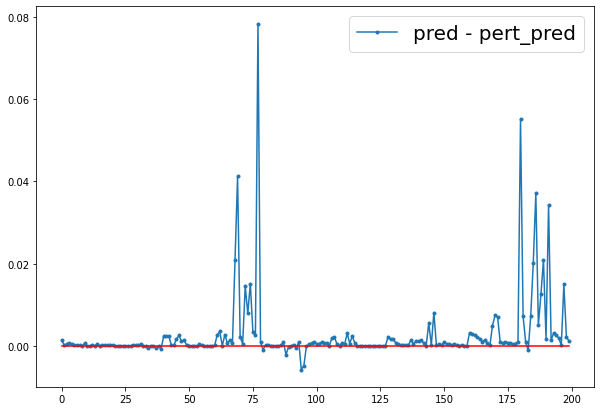

In [70]:
model = model_eval

with torch.no_grad():
    output = model(test_x_list, alpha=0.2)
    
    # perturbed input and its output
    pert_test_x = []
    for _test_x in test_x_list:
         pert_test_x.append(_test_x.detach().clone())

    # Perturbations on price
    perturbations =1.0*torch.rand((test_x_list[0].shape[0], ), device=device)    # two angular velocities
    pert_test_x[0][:,0] += perturbations    # 0-th feature : week_sell_price

    pert_output = model(pert_test_x, alpha=0.2)    # \hat{y}_{p}    predicted sales from perturbed input
    
test_ratio = verification(output, pert_output, threshold=0.0).item()

print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, _alpha))
        
min_ind, max_ind = 100, 300 

plt.figure(0, figsize=(10,7))
# plt.plot(output.cpu()[min_ind:max_ind], '.-', label='pred')
# plt.plot(pert_output.cpu()[min_ind:max_ind], '.-', label='pert pred')
plt.plot((output.cpu() - pert_output.cpu())[min_ind:max_ind], '.-', label='pred - pert_pred')
plt.plot([0.0]*(max_ind-min_ind), 'r')
plt.legend(fontsize=20)

In [29]:
# ret_dict = {}
# ret_dict['test_loss_data_only'] = test_loss_alpha
# ret_dict['test_ratio_data_only'] = test_ratio_alpha
ret_dict['test_loss_hybrid'] = test_loss_alpha
ret_dict['test_ratio_hybrid'] = test_ratio_alpha

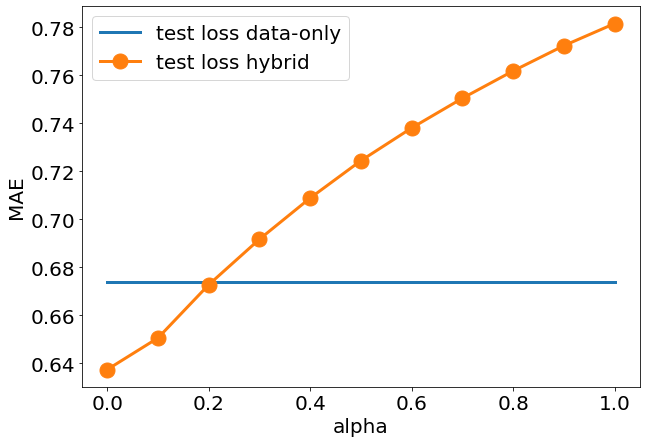

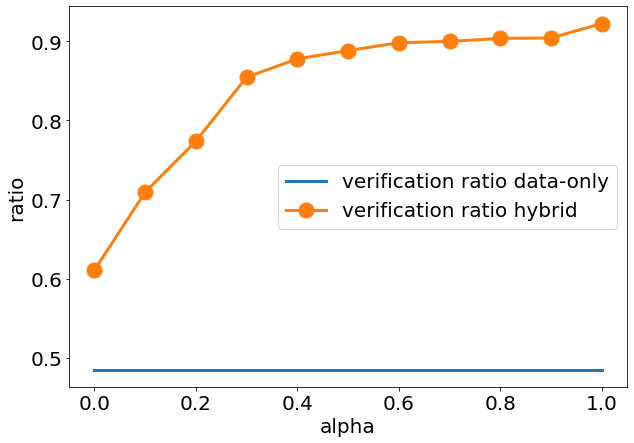

In [37]:
plt.figure(0, figsize=(10,7))
plt.plot(alphas, ret_dict['test_loss_data_only'][:1]*len(alphas), '-', lw=3, label='test loss data-only')
plt.plot(alphas, ret_dict['test_loss_hybrid'], 'o-', lw=3, ms=15, label='test loss hybrid')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(alphas, ret_dict['test_ratio_data_only'][:1]*len(alphas), '-', lw=3, label='verification ratio data-only')
plt.plot(alphas, ret_dict['test_ratio_hybrid'], 'o-', lw=3, ms=15, label='verification ratio hybrid')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

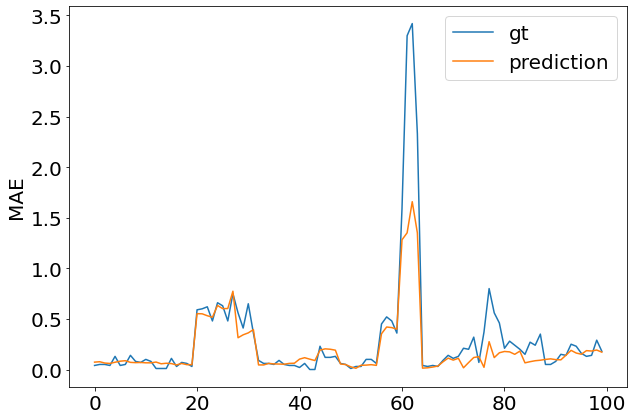

In [18]:
model = model_eval

with torch.no_grad():
    output = model(test_x_list, alpha=0.0)
    
min_ind, max_ind = 100, 200    
plt.figure(0, figsize=(10,7))
plt.plot(test_y.cpu()[min_ind:max_ind], '-', label='gt')
plt.plot(output.cpu()[min_ind:max_ind], '-', label='prediction')
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [19]:
data_only_output = output

## Tensorflow implementation (Not working yet)

In [7]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, Layer
from tensorflow.keras.models import Model


class Net(Model):
    
    def __init__(self, data_info, threshold=0.7):
        super(Net, self).__init__()
        self.reg = MyActivityRegularizer()
        
        gc.collect()
        
        # Dense input
#         self.dense_input = Input(shape=(len(dense_cols), ), name='dense1')

        # Embedding input
        self.item_id_layer = Embedding(data_info['item_id'], 3)
        self.dept_id_layer = Embedding(data_info['dept_id'], 1)
        self.store_id_layer = Embedding(data_info['store_id'], 1)
        self.cat_id_layer = Embedding(data_info['cat_id'], 1)
        self.state_id_layer = Embedding(data_info['state_id'], 1)
        
        # Rule encoder
        self.rule_dense1 = Dense(16, activation='relu')
        self.rule_dense2 = Dense(16, activation='tanh')
        
        # Data encoder
        self.data_dense1 = Dense(16, activation='relu')
        self.data_dense2 = Dense(16, activation='tanh')
        
        # Task layer
        self.dense1 = Dense(16, activation='relu')
        self.dense2 = Dense(1, activation='linear')
        
    
    def call(self, inputs, alpha=0.0):
        item_id_emb = Flatten()(self.item_id_layer(inputs['item_id']))
        dept_id_emb = Flatten()(self.dept_id_layer(inputs['dept_id']))
        store_id_emb = Flatten()(self.store_id_layer(inputs['store_id']))
        cat_id_emb = Flatten()(self.cat_id_layer(inputs['cat_id']))
        state_id_emb = Flatten()(self.state_id_layer(inputs['state_id']))
    
        # Combine dense and embedding parts and add dense layers. Exit on linear scale.
        x = concatenate([inputs['dense1'], item_id_emb, dept_id_emb, store_id_emb, cat_id_emb, state_id_emb])
        
        #### Rule embedding
        rule_z = self.rule_dense1(x)
        rule_z = self.rule_dense2(rule_z)
        
        #### Data embedding
        data_z = self.data_dense1(x)
        data_z = self.data_dense2(data_z)
        
        #### weighted concatentation
        z = concatenate([alpha*rule_z, (1-alpha)*data_z], axis=1)
        
        #### Prediction
        out = self.dense1(z)
        out = self.dense2(out)    # (batch, 1)
        
        return out

# Set a model
model = Net(data_info, 0.0)

def my_loss_fn(y_true, y_pred):
        abs_difference = tf.abs(y_true - y_pred)
        return tf.reduce_mean(abs_difference, axis=-1)
        
model.compile(loss=my_loss_fn,
              metrics=["mse"],
              optimizer=keras.optimizers.Adam(learning_rate=0.001))